Продолжение первого ноутбука

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import ujson
import tqdm

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
import seaborn as sns
import catboost
import xgboost
import lightgbm
from sklearn.ensemble import (VotingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler

from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

# Загрузка всех данных

In [14]:
PATH_TO_DATA = "../data/"

In [98]:
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data_1.csv"), 
                                    index_col="match_id_hash")
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data_1.csv"), 
                                            index_col="match_id_hash")

In [15]:
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")


In [99]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

In [100]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=total_matches):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        # и другие данные
        first_blood = 0
        aegis_stolen_radiant, aegis_stolen_dire = 0, 0
        aegis_denied_radiant, aegis_denied_dire = 0, 0
        radiant_roshan_kills, dire_roshan_kills = 0, 0
        barracks_kill = 0
        dire_ability_uses = 0
        rad_ability_uses = 0
        
        dire_observers_placed, rad_observers_placed = 0, 0
        dire_purchase_log, rad_purchase_log = 0, 0
        dire_inventory, rad_inventory = 0, 0
        
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                barracks_kill += 1
                    
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["player_slot"] < 6:
                    first_blood = 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS_STOLEN":
                if objective["player_slot"] < 6:
                    aegis_stolen_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_stolen_dire += 1
            
            if objective["type"] == "CHAT_MESSAGE_DENIED_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_denied_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_denied_dire += 1
                    
        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        df_features.loc[match_id_hash, "first_blood"] = first_blood
        df_features.loc[match_id_hash, "barracks_kill"] = barracks_kill       
        
        df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant - aegis_stolen_dire
        df_features.loc[match_id_hash, "aegis_stolen_radiant"] = aegis_stolen_radiant
        df_features.loc[match_id_hash, "aegis_stolen_dire"] = aegis_stolen_dire
            
        df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant - aegis_denied_dire
        df_features.loc[match_id_hash, "aegis_denied_radiant"] = aegis_denied_radiant
        df_features.loc[match_id_hash, "aegis_denied_dire"] = aegis_denied_dire
        
        for player in match["players"]:
            if player['player_slot'] > 90:
                for i in player["ability_uses"].values():
                    dire_ability_uses += i
            else:
                for i in player["ability_uses"].values():
                    rad_ability_uses += i
                    
            if player['player_slot'] > 90:
                dire_observers_placed += player["observers_placed"]
                dire_purchase_log += len(player["purchase_log"])
                dire_inventory += len(player["hero_inventory"])

            else:
                rad_observers_placed += player["observers_placed"]
                rad_purchase_log += len(player["purchase_log"])
                rad_inventory += len(player["hero_inventory"])
                
        df_features.loc[match_id_hash, "dire_purchases"] = dire_purchase_log
        df_features.loc[match_id_hash, "rad_purchases"] = rad_purchase_log 
        
        df_features.loc[match_id_hash, "dire_inventory"] = dire_inventory
        df_features.loc[match_id_hash, "rad_inventory"] = rad_inventory 
        
        df_features.loc[match_id_hash, "rad_ability_uses"] = rad_ability_uses
        df_features.loc[match_id_hash, "dire_ability_uses"] = dire_ability_uses 
        
        for team_fight in match["teamfights"]:
            for i, team_player in enumerate(team_fight['players']):
                if i < 10:
                    df_features.loc[match_id_hash, f"r{i+1}_damage"] = team_player.get("damage", 0)
                    df_features.loc[match_id_hash, f"r{i+1}_healing"] = team_player.get("healing", 0)
                    
                else:
                    df_features.loc[match_id_hash, f"d{i-4}_damage"] = team_player.get("damage", 0)      
                    df_features.loc[match_id_hash, f"d{i-4}_healing"] = team_player.get("healing", 0)  

In [101]:
add_new_features(df_train_features, 
                 os.path.join('../data', 
                              "train_raw_data.jsonl"),
                 total_matches = 31698)

  0%|          | 0/31698 [00:00<?, ?it/s]

In [102]:
# Добавим новые
add_new_features(df_test_features, 
                 os.path.join('../data', 
                              "test_raw_data.jsonl"),
                 total_matches = 7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [105]:
#df_train_features.to_csv('../data/read_fin_train.csv')  
#df_test_features.to_csv('../data/read_fin_test.csv')  

In [127]:
train = pd.read_csv('../data/read_fin_train.csv', index_col=0)
test = pd.read_csv('../data/read_fin_test.csv', index_col=0)

In [106]:
#train = df_train_features.copy()
#test = df_test_features.copy()

In [16]:
y = df_train_targets["radiant_win"].values.astype("int8")

In [256]:
train.to_csv('../data/fin_train.csv')  
test.to_csv('../data/fin_test.csv')  

In [326]:
train = pd.read_csv('../data/fin_train.csv', index_col=0)
test = pd.read_csv('../data/fin_test.csv', index_col=0)

# Работа с данными

In [129]:
# id hero to hero win rate

id_hero = set(list(train['r1_hero_id']))

new_train = train.copy()
new_train['win'] = y

win_rate_for_hero = dict()

for index, row in train.iterrows():
    for i in range(1, 6):
        try:
            win_rate_for_hero[row[f'r{i}_hero_id']] += new_train.loc[index, 'win']

        except KeyError:
            win_rate_for_hero[row[f'r{i}_hero_id']] = new_train.loc[index, 'win']
            
        try:
            win_rate_for_hero[row[f'd{i}_hero_id']] += new_train.loc[index, 'win']

        except KeyError:
            win_rate_for_hero[row[f'd{i}_hero_id']] = new_train.loc[index, 'win']
            
for h_id in win_rate_for_hero:
    win_rate_for_hero[h_id] = win_rate_for_hero[h_id] / new_train.shape[0]
    
for index, row in new_train.iterrows():
    for i in range(1, 6):
        train.loc[index, f"r{i}h_win_rate"] = win_rate_for_hero[row[f"r{i}_hero_id"]]
        train.loc[index, f"d{i}h_win_rate"] = win_rate_for_hero[row[f"d{i}_hero_id"]]
    
for i in range(1, 6):
    train = train.drop([f"r{i}_hero_id", f"d{i}_hero_id"], axis=1)

In [130]:
for index, row in test.iterrows():
    for i in range(1, 6):
        test.loc[index, f"r{i}h_win_rate"] = win_rate_for_hero[row[f"r{i}_hero_id"]]
        test.loc[index, f"d{i}h_win_rate"] = win_rate_for_hero[row[f"d{i}_hero_id"]]
    
for i in range(1, 6):
    test = test.drop([f"r{i}_hero_id", f"d{i}_hero_id"], axis=1)

In [133]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# LogisticRegression: 0.8105232298578847

In [135]:
test['r_max_mana'] = 0
test['d_max_mana'] = 0

for i in range(1, 6):
    test['r_max_mana'] += test[f'r{i}_max_mana']
    test['d_max_mana'] += test[f'd{i}_max_mana']
    
    test = test.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
test['diff_max_mana'] = (test['r_max_mana'] + 1) / (test['d_max_mana'] + 1)

test = test.drop(['r_max_mana', 'd_max_mana'], axis=1)

In [136]:
train['r_max_mana'] = 0
train['d_max_mana'] = 0

for i in range(1, 6):
    train['r_max_mana'] += train[f'r{i}_max_mana']
    train['d_max_mana'] += train[f'd{i}_max_mana']
    
    train = train.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
train['diff_max_mana'] = (train['r_max_mana'] + 1) / (train['d_max_mana'] + 1)

train = train.drop(['r_max_mana', 'd_max_mana'], axis=1)
# LogisticRegression: 0.8107347130416839

In [139]:
test['r_creeps_stacked'] = 0
test['d_creeps_stacked'] = 0
test['r_camps_stacked'] = 0
test['d_camps_stacked'] = 0


for i in range(1, 6):
    test['r_creeps_stacked'] += test[f'r{i}_creeps_stacked'] 
    test['d_creeps_stacked'] += test[f'd{i}_creeps_stacked'] 
    
    test['r_camps_stacked'] += test[f'r{i}_camps_stacked'] 
    test['d_camps_stacked'] += test[f'd{i}_camps_stacked'] 
    
    test = test.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [140]:
train['r_creeps_stacked'] = 0
train['d_creeps_stacked'] = 0
train['r_camps_stacked'] = 0
train['d_camps_stacked'] = 0


for i in range(1, 6):
    train['r_creeps_stacked'] += train[f'r{i}_creeps_stacked'] 
    train['d_creeps_stacked'] += train[f'd{i}_creeps_stacked'] 
    
    train['r_camps_stacked'] += train[f'r{i}_camps_stacked'] 
    train['d_camps_stacked'] += train[f'd{i}_camps_stacked'] 
    
    train = train.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)
    
# LogisticRegression: 0.810941765578241

In [145]:
train['d_rune_pickups'] = 0
train['r_rune_pickups'] = 0

test['d_rune_pickups'] = 0
test['r_rune_pickups'] = 0

for i in range(1, 6):
    train['d_rune_pickups'] += train[f'd{i}_rune_pickups'] 
    train['r_rune_pickups'] += train[f'r{i}_rune_pickups'] 
    
    train = train.drop([f'r{i}_rune_pickups', f'd{i}_rune_pickups',], axis=1)
    
    test['d_rune_pickups'] += test[f'd{i}_rune_pickups'] 
    test['r_rune_pickups'] += test[f'r{i}_rune_pickups'] 
    
    test = test.drop([f'r{i}_rune_pickups', f'd{i}_rune_pickups',], axis=1)
    
# LogisticRegression: 0.8111139580828519

In [148]:
train['d_obs_placed'] = 0
train['r_obs_placed'] = 0

test['d_obs_placed'] = 0
test['r_obs_placed'] = 0

for i in range(1, 6):
    train['d_obs_placed'] += train[f'd{i}_obs_placed'] 
    train['r_obs_placed'] += train[f'r{i}_obs_placed'] 
    
    train = train.drop([f'r{i}_obs_placed', f'd{i}_obs_placed',], axis=1)
    
    test['d_obs_placed'] += test[f'd{i}_obs_placed'] 
    test['r_obs_placed'] += test[f'r{i}_obs_placed'] 
    
    test = test.drop([f'r{i}_obs_placed', f'd{i}_obs_placed',], axis=1)
    
# LogisticRegression: 0.8112648829339387

In [152]:
train['d_healing'] = 0
train['r_healing'] = 0

test['d_healing'] = 0
test['r_healing'] = 0

for i in range(1, 6):
    train['d_healing'] += train[f'd{i}_healing'] 
    train['r_healing'] += train[f'r{i}_healing'] 
    
    test['d_healing'] += test[f'd{i}_healing'] 
    test['r_healing'] += test[f'r{i}_healing'] 
    
    train = train.drop([f'r{i}_healing', f'd{i}_healing',], axis=1)
    test = test.drop([f'r{i}_healing', f'd{i}_healing',], axis=1)

# LogisticRegression: 0.8113630693326256

In [157]:
train['d_denies'] = 0
train['r_denies'] = 0

test['d_denies'] = 0
test['r_denies'] = 0

for i in range(1, 6):
    train['d_denies'] += train[f'd{i}_denies'] 
    train['r_denies'] += train[f'r{i}_denies'] 
    
    train = train.drop([f'r{i}_denies', f'd{i}_denies',], axis=1)
    
    test['d_denies'] += test[f'd{i}_denies'] 
    test['r_denies'] += test[f'r{i}_denies'] 
    
    test = test.drop([f'r{i}_denies', f'd{i}_denies',], axis=1)
    
# LogisticRegression: 0.8113630693326256

In [160]:
train['rat_purchases'] = np.where(train['dire_purchases'] > 0,
                                   train['rad_purchases']  / train['dire_purchases'],
                                   train['rad_purchases'])

test['rat_purchases'] = np.where(test['dire_purchases'] > 0,
                                   test['rad_purchases']  / test['dire_purchases'],
                                   test['rad_purchases'])

train = train.drop(['rad_purchases', 'dire_purchases'], axis=1)
test = test.drop(['rad_purchases', 'dire_purchases'], axis=1)

# LogisticRegression: 0.8122969316307732

In [163]:
train['d_damage'] = 0
train['r_damage'] = 0

test['d_damage'] = 0
test['r_damage'] = 0

for i in range(1, 6):
    train['d_damage'] += train[f'd{i}_damage'] 
    train['r_damage'] += train[f'r{i}_damage'] 
    
    train = train.drop([f'r{i}_damage', f'd{i}_damage',], axis=1)
    
    test['d_damage'] += test[f'd{i}_damage'] 
    test['r_damage'] += test[f'r{i}_damage'] 
    
    test = test.drop([f'r{i}_damage', f'd{i}_damage',], axis=1)
    
# LogisticRegression: 0.8123944574517011

In [277]:
for i in range(1, 6):    
    train[f'd{i}_KDA'] = np.where(train[f'd{i}_deaths'] > 0,
                                 (train[f'd{i}_kills'] + train[f'd{i}_assists']) / train[f'd{i}_deaths'],
                                  train[f'd{i}_kills'] + train[f'd{i}_assists'])
    
    train[f'r{i}_KDA'] = np.where(train[f'r{i}_deaths'] > 0,
                                 (train[f'r{i}_kills'] + train[f'r{i}_assists']) / train[f'r{i}_deaths'],
                                  train[f'r{i}_kills'] + train[f'r{i}_assists'])
    
    train = train.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)
    
    test[f'd{i}_KDA'] = np.where(test[f'd{i}_deaths'] > 0,
                                  (test[f'd{i}_kills'] + test[f'd{i}_assists']) / test[f'd{i}_deaths'],
                                   test[f'd{i}_kills'] + test[f'd{i}_assists'])
    
    test[f'r{i}_KDA'] = np.where(test[f'r{i}_deaths'] > 0,
                                 (test[f'r{i}_kills'] + test[f'r{i}_assists']) / test[f'r{i}_deaths'],
                                  test[f'r{i}_kills'] + test[f'r{i}_assists'])
    
    test = test.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)
    
# LogisticRegression: 0.8128608374551053

KeyError: 'd1_deaths'

In [280]:
train['d_roshans_killed'] = 0
train['r_roshans_killed'] = 0

test['r_roshans_killed'] = 0
test['d_roshans_killed'] = 0

for i in range(1, 6):
    train['d_roshans_killed'] += train[f'd{i}_roshans_killed'] 
    train['r_roshans_killed'] += train[f'r{i}_roshans_killed'] 
    
    train = train.drop([f'r{i}_roshans_killed', f'd{i}_roshans_killed',], axis=1)
    
    test['d_roshans_killed'] += test[f'd{i}_roshans_killed'] 
    test['r_roshans_killed'] += test[f'r{i}_roshans_killed'] 
    
    test = test.drop([f'r{i}_roshans_killed', f'd{i}_roshans_killed',], axis=1)

KeyError: 'd1_roshans_killed'

In [282]:
for i in range(1, 6):
    train = train.drop(['dire_roshan_kills',
                        'radiant_roshan_kills'],
                      axis=1)
    
    test = test.drop(['dire_roshan_kills',
                      'radiant_roshan_kills'],
                      axis=1)
    
# LogisticRegression: 0.8129872586252871

KeyError: "['dire_roshan_kills', 'radiant_roshan_kills'] not found in axis"

In [283]:
train['d_stuns'] = 0
train['r_stuns'] = 0

test['d_stuns'] = 0
test['r_stuns'] = 0

for i in range(1, 6):
    train['d_stuns'] += train[f'd{i}_stuns'] 
    train['r_stuns'] += train[f'r{i}_stuns'] 
    
    train = train.drop([f'r{i}_stuns', f'd{i}_stuns',], axis=1)
    
    test['d_stuns'] += test[f'd{i}_stuns'] 
    test['r_stuns'] += test[f'r{i}_stuns'] 
    
    test = test.drop([f'r{i}_stuns', f'd{i}_stuns',], axis=1)
    
# LogisticRegression: 0.8130763174865153

KeyError: 'd1_stuns'

In [284]:
train['r_lh'] = 0
train['d_lh'] = 0

test['r_lh'] = 0
test['d_lh'] = 0

for i in range(1, 6):
    train['r_lh'] += train[f'r{i}_lh'] 
    train['d_lh'] += train[f'd{i}_lh']
    
    train = train.drop([f'r{i}_lh',
                        f'd{i}_lh'],
                      axis=1)
    
    test['r_lh'] += test[f'r{i}_lh'] 
    test['d_lh'] += test[f'd{i}_lh']
    
    test = test.drop([f'r{i}_lh',
                        f'd{i}_lh'],
                      axis=1)
    
# LogisticRegression: 0.8132250386671416

KeyError: 'r1_lh'

In [285]:
train['rat_creeps_stacked'] = np.where(train['d_creeps_stacked'] > 0,
                                      train['r_creeps_stacked'] / train['d_creeps_stacked'],
                                      train['r_creeps_stacked'])

train['rat_camps_stacked'] = np.where(train['d_camps_stacked'] > 0,
                                      train['r_camps_stacked'] / train['d_camps_stacked'],
                                      train['r_camps_stacked'])

test['rat_creeps_stacked'] = np.where(test['d_creeps_stacked'] > 0,
                                      test['r_creeps_stacked'] / test['d_creeps_stacked'],
                                      test['r_creeps_stacked'])

test['rat_camps_stacked'] = np.where(test['d_camps_stacked'] > 0,
                                      test['r_camps_stacked'] / test['d_camps_stacked'],
                                      test['r_camps_stacked'])

train = train.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

test = test.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

# LogisticRegression: 0.8132644733566305

KeyError: 'd_creeps_stacked'

In [286]:
train['d_xp'] = 0
train['r_xp'] = 0

test['d_xp'] = 0
test['r_xp'] = 0

for i in range(1, 6):
    train['d_xp'] += train[f'd{i}_xp'] 
    train['r_xp'] += train[f'r{i}_xp'] 
    
    train = train.drop([f'r{i}_xp',
                        f'd{i}_xp',],
                        axis=1)
    
    test['d_xp'] += test[f'd{i}_xp'] 
    test['r_xp'] += test[f'r{i}_xp'] 
    
    test = test.drop([f'r{i}_xp',
                        f'd{i}_xp',],
                        axis=1)
    
    
train['d_xp'] = train['d_xp'] / 5
train['r_xp'] = train['r_xp'] / 5

test['d_xp'] = test['d_xp'] / 5
test['r_xp'] = test['r_xp'] / 5

# LogisticRegression: 0.8133530536171455

KeyError: 'd1_xp'

In [287]:
train['d_towers_killed'] = 0
train['r_towers_killed'] = 0

test['r_towers_killed'] = 0
test['d_towers_killed'] = 0

for i in range(1, 6):
    train['d_towers_killed'] += train[f'd{i}_towers_killed'] 
    train['r_towers_killed'] += train[f'r{i}_towers_killed'] 
    
    train = train.drop([f'r{i}_towers_killed', f'd{i}_towers_killed',], axis=1)
    
    test['d_towers_killed'] += test[f'd{i}_towers_killed'] 
    test['r_towers_killed'] += test[f'r{i}_towers_killed'] 
    
    test = test.drop([f'r{i}_towers_killed', f'd{i}_towers_killed',], axis=1)
    
train = train.drop(['dire_tower_kills', 'radiant_tower_kills'], axis=1)
test = test.drop(['dire_tower_kills', 'radiant_tower_kills'], axis=1)

# LogisticRegression: 0.8134436703592831

KeyError: 'd1_towers_killed'

In [315]:
train['d_max_health'] = 0
train['r_max_health'] = 0

test['r_max_health'] = 0
test['d_max_health'] = 0

for i in range(1, 6):
    train['d_max_health'] += train[f'd{i}_max_health'] 
    train['r_max_health'] += train[f'r{i}_max_health'] 
    
    train = train.drop([f'r{i}_max_health', f'd{i}_max_health',], axis=1)
    
    test['d_max_health'] += test[f'd{i}_max_health'] 
    test['r_max_health'] += test[f'r{i}_max_health'] 
    
    test = test.drop([f'r{i}_max_health', f'd{i}_max_health',], axis=1)

train['rat_max_health'] = train['r_max_health'] / train['d_max_health'] 
test['rat_max_health'] = test['r_max_health'] / test['d_max_health'] 

# LogisticRegression: 0.8138195499389459

In [326]:
train['d_sen_placed'] = 0
train['r_sen_placed'] = 0

test['d_sen_placed'] = 0
test['r_sen_placed'] = 0

for i in range(1, 6):
    train['d_sen_placed'] += train[f'd{i}_sen_placed'] 
    train['r_sen_placed'] += train[f'r{i}_sen_placed'] 
    
    train = train.drop([f'r{i}_sen_placed', f'd{i}_sen_placed',], axis=1)
    
    test['d_sen_placed'] += test[f'd{i}_sen_placed'] 
    test['r_sen_placed'] += test[f'r{i}_sen_placed'] 
    
    test = test.drop([f'r{i}_sen_placed', f'd{i}_sen_placed',], axis=1)
    
train['rat_sen_placed'] = np.where(train['d_sen_placed'] > 0,
                                   train['r_sen_placed'] / train['d_sen_placed'],
                                   train['r_sen_placed'])

test['rat_sen_placed'] = np.where(test['d_sen_placed'] > 0,
                                   test['r_sen_placed'] / test['d_sen_placed'],
                                   test['r_sen_placed'])

# LogisticRegression: 0.8139630243348902

In [338]:
train['d_health'] = 0
train['r_health'] = 0

test['r_health'] = 0
test['d_health'] = 0

for i in range(1, 6):
    train['d_health'] += train[f'd{i}_health'] 
    train['r_health'] += train[f'r{i}_health'] 
    
    train = train.drop([f'r{i}_health', f'd{i}_health',], axis=1)
    
    test['d_health'] += test[f'd{i}_health'] 
    test['r_health'] += test[f'r{i}_health'] 
    
    test = test.drop([f'r{i}_health', f'd{i}_health',], axis=1)

train['max_health'] = np.where(train['d_health'] > 0,
                              train['r_health'] / train['d_health'],
                              train['r_health'])

test['max_health'] = np.where(test['d_health'] > 0,
                              test['r_health'] / test['d_health'],
                              test['r_health'])

# LogisticRegression: 0.8142539523274858

In [44]:
train['d_gold'] = 0
train['r_gold'] = 0

test['r_gold'] = 0
test['d_gold'] = 0

for i in range(1, 6):
    train['d_gold'] += train[f'd{i}_gold'] 
    train['r_gold'] += train[f'r{i}_gold'] 
    
    train = train.drop([f'r{i}_gold', f'd{i}_gold',], axis=1)
    
    test['d_gold'] += test[f'd{i}_gold'] 
    test['r_gold'] += test[f'r{i}_gold'] 
    
    test = test.drop([f'r{i}_gold', f'd{i}_gold',], axis=1)

train['rat_gold'] = np.where(train['d_gold'] > 0,
                              train['r_gold'] / train['d_gold'],
                              train['r_gold'])

test['rat_gold'] = np.where(test['d_gold'] > 0,
                              test['r_gold'] / test['d_gold'],
                              test['r_gold'])

# LogisticRegression: 0.8151582034478485

In [45]:
train['rat_lh'] = np.where(train['d_lh'] > 0,
                              train['r_lh'] / train['d_lh'],
                              train['r_lh'])

test['rat_lh'] = np.where(test['d_lh'] > 0,
                              test['r_lh'] / test['d_lh'],
                              test['r_lh'])

# LogisticRegression: 0.815599608624373

In [46]:
train = train.drop(['r_lh', 'd_lh'], axis=1)
test = test.drop(['r_lh', 'd_lh'], axis=1)
# LogisticRegression: 0.8156045783311573

In [47]:
train['rat_xp'] = np.where(train['d_xp'] > 0,
                              train['r_xp'] / train['d_xp'],
                              train['r_xp'])

test['rat_xp'] = np.where(test['d_xp'] > 0,
                              test['r_xp'] / test['d_xp'],
                              test['r_xp'])

train = train.drop(['r_xp', 'd_xp'], axis=1)
test = test.drop(['r_xp', 'd_xp'], axis=1)

# LogisticRegression: 0.8155726873510396

In [48]:
train['d_level'] = 0
train['r_level'] = 0

test['r_level'] = 0
test['d_level'] = 0

for i in range(1, 6):
    train['d_level'] += train[f'd{i}_level'] 
    train['r_level'] += train[f'r{i}_level'] 
    
    train = train.drop([f'r{i}_level', f'd{i}_level',], axis=1)
    
    test['d_level'] += test[f'd{i}_level'] 
    test['r_level'] += test[f'r{i}_level'] 
    
    test = test.drop([f'r{i}_level', f'd{i}_level',], axis=1)

train['rat_level'] = np.where(train['d_level'] > 0,
                              train['r_level'] / train['d_level'],
                              train['r_level'])

test['rat_level'] = np.where(test['d_level'] > 0,
                              test['r_level'] / test['d_level'],
                              test['r_level'])

# LogisticRegression: 0.8155797885913502

In [81]:
train['d_teamfight_participation'] = 0
train['r_teamfight_participation'] = 0

test['r_teamfight_participation'] = 0
test['d_teamfight_participation'] = 0

for i in range(1, 6):
    train['d_teamfight_participation'] += train[f'd{i}_teamfight_participation'] 
    train['r_teamfight_participation'] += train[f'r{i}_teamfight_participation'] 
    
    train = train.drop([f'r{i}_teamfight_participation', f'd{i}_teamfight_participation',], axis=1)
    
    test['d_teamfight_participation'] += test[f'd{i}_teamfight_participation'] 
    test['r_teamfight_participation'] += test[f'r{i}_teamfight_participation'] 
    
    test = test.drop([f'r{i}_teamfight_participation', f'd{i}_teamfight_participation',], axis=1)

train['rat_teamfight_participation'] = np.where(train['d_teamfight_participation'] > 0,
                              train['r_teamfight_participation'] / train['d_teamfight_participation'],
                              train['r_teamfight_participation'])

test['rat_teamfight_participation'] = np.where(test['d_teamfight_participation'] > 0,
                              test['r_teamfight_participation'] / test['d_teamfight_participation'],
                              test['r_teamfight_participation'])

# LogisticRegression: 0.8157410469331051

In [238]:
test = test.drop(['d_max_health'], axis=1)
train = train.drop(['d_max_health'], axis=1)
# LogisticRegression: 0.8156962000854211 -- хуже

In [239]:
test = test.drop(['game_time'], axis=1)
train = train.drop(['game_time'], axis=1)
# LogisticRegression: 0.8157315265373138

In [240]:
train['d_firstblood_claimed'] = 0
train['r_firstblood_claimed'] = 0

test['r_firstblood_claimed'] = 0
test['d_firstblood_claimed'] = 0

for i in range(1, 6):
    train['d_firstblood_claimed'] += train[f'd{i}_firstblood_claimed'] 
    train['r_firstblood_claimed'] += train[f'r{i}_firstblood_claimed'] 
    
    train = train.drop([f'r{i}_firstblood_claimed', f'd{i}_firstblood_claimed',], axis=1)
    
    test['d_firstblood_claimed'] += test[f'd{i}_firstblood_claimed'] 
    test['r_firstblood_claimed'] += test[f'r{i}_firstblood_claimed'] 
    
    test = test.drop([f'r{i}_firstblood_claimed', f'd{i}_firstblood_claimed',], axis=1)

train['rat_firstblood_claimed'] = np.where(train['d_firstblood_claimed'] > 0,
                              train['r_firstblood_claimed'] / train['d_firstblood_claimed'],
                              train['r_firstblood_claimed'])

test['rat_firstblood_claimed'] = np.where(test['d_firstblood_claimed'] > 0,
                              test['r_firstblood_claimed'] / test['d_firstblood_claimed'],
                              test['r_firstblood_claimed'])

# LogisticRegression: 0.815526211487776

In [241]:
test = test.drop(['r_firstblood_claimed', 'rat_firstblood_claimed'], axis=1)
train = train.drop(['r_firstblood_claimed', 'rat_firstblood_claimed'], axis=1)

train['rat_damage'] = np.where(train['d_damage'] > 0,
                              train['r_damage'] / train['d_damage'],
                              train['r_damage'])

test['rat_damage'] = np.where(test['d_damage'] > 0,
                              test['r_damage'] / test['d_damage'],
                              test['r_damage'])

test = test.drop(['r_damage'], axis=1)
train = train.drop(['r_damage'], axis=1)

# LogisticRegression: 0.8154044368609757

In [242]:
train['sum_creep_camp_stacked'] = train['rat_creeps_stacked'] + train['rat_camps_stacked'] 
test['sum_creep_camp_stacked'] = test['rat_creeps_stacked'] + test['rat_camps_stacked'] 
    
test = test.drop(['rat_creeps_stacked', 'rat_camps_stacked'], axis=1)
train = train.drop(['rat_creeps_stacked', 'rat_camps_stacked'], axis=1)

# LogisticRegression: 0.8154047722011453

In [243]:
test = test.drop(['r_stuns'], axis=1)
train = train.drop(['r_stuns'], axis=1)

# LogisticRegression: 0.815429704447268

In [244]:
test = test.drop(['objectives_len', 'lobby_type'], axis=1)
train = train.drop(['objectives_len', 'lobby_type'], axis=1)

In [245]:
train['rat_denies'] = np.where(train['d_denies'] > 0,
                              train['r_denies'] / train['d_denies'],
                              train['r_denies'])

test['rat_denies'] = np.where(test['d_denies'] > 0,
                              test['r_denies'] / test['d_denies'],
                              test['r_denies'])


train['rat_rune_pickups'] = np.where(train['d_rune_pickups'] > 0,
                              train['r_rune_pickups'] / train['d_rune_pickups'],
                              train['r_rune_pickups'])

test['rat_rune_pickups'] = np.where(test['d_rune_pickups'] > 0,
                              test['r_rune_pickups'] / test['d_rune_pickups'],
                              test['r_rune_pickups'])

train['d_obs_placed'] = np.where(train['d_obs_placed'] > 0,
                              train['r_obs_placed'] / train['d_obs_placed'],
                              train['r_obs_placed'])

test['d_obs_placed'] = np.where(test['d_obs_placed'] > 0,
                              test['r_obs_placed'] / test['d_obs_placed'],
                              test['r_obs_placed'])

test = test.drop(['d_denies', 'd_rune_pickups'], axis=1)
train = train.drop(['d_denies', 'd_rune_pickups'], axis=1)

# LogisticRegression: 0.8159764118520697

In [246]:
test['rat_inventory'] = np.where(test['dire_inventory'] > 0,
                              test['rad_inventory'] / test['dire_inventory'],
                              test['rad_inventory'])

train['rat_inventory'] = np.where(train['dire_inventory'] > 0,
                              train['rad_inventory'] / train['dire_inventory'],
                              train['rad_inventory'])

test = test.drop(['dire_inventory'], axis=1)
train = train.drop(['dire_inventory'], axis=1)
                  
# LogisticRegression: 0.816003475660664

In [247]:
test = test.drop(['aegis_stolen_radiant', 'aegis_stolen_dire',
                  'aegis_denied_radiant', 'aegis_denied_dire'], axis=1)
train = train.drop(['aegis_stolen_radiant', 'aegis_stolen_dire',
                  'aegis_denied_radiant', 'aegis_denied_dire'], axis=1)

# LogisticRegression: 0.8160789074734427

In [248]:
test = test.drop(['r_max_health'], axis=1)
train = train.drop(['r_max_health'], axis=1)

test = test.drop(['d_firstblood_claimed'], axis=1)
train = train.drop(['d_firstblood_claimed'], axis=1)

# LogisticRegression: 0.8160978886818543

In [249]:
for i in range(1, 6):
    train[f'r{i}_xy'] = (train[f'r{i}_x'] + train[f'r{i}_y']) / 2
    train[f'd{i}_xy'] = (train[f'd{i}_x'] + train[f'd{i}_y']) / 2
    
    test[f'r{i}_xy'] = (test[f'r{i}_x'] + test[f'r{i}_y']) / 2
    test[f'd{i}_xy'] = (test[f'd{i}_x'] + test[f'd{i}_y']) / 2
    
    test = test.drop([f'r{i}_x', f'd{i}_x', f'r{i}_y', f'd{i}_y'], axis=1)
    train = train.drop([f'r{i}_x', f'd{i}_x', f'r{i}_y', f'd{i}_y'], axis=1)
    
# LogisticRegression: 0.8165489119054375

In [ ]:
# run after read csv

In [327]:
train['aegis_stolen_deneied'] = train['aegis_stolen_diff'] + train['aegis_denied_diff']
test['aegis_stolen_deneied'] = test['aegis_stolen_diff'] + test['aegis_denied_diff']

test = test.drop(['aegis_stolen_diff', 'aegis_denied_diff', 'barracks_kill'], axis=1)
train = train.drop(['aegis_stolen_diff', 'aegis_denied_diff', 'barracks_kill'], axis=1)
# LogisticRegression: 0.8165509599067894

In [328]:
test = test.drop(['chat_len', 'game_mode'], axis=1)
train = train.drop(['chat_len', 'game_mode'], axis=1)

In [329]:
test['rat_healing'] = np.where(test['d_healing'] > 0,
                              test['r_healing'] / test['d_healing'],
                              test['r_healing'])

train['rat_healing'] = np.where(train['d_healing'] > 0,
                              train['r_healing'] / train['d_healing'],
                              train['r_healing'])

test = test.drop(['d_healing'], axis=1)
train = train.drop(['d_healing'], axis=1)
                  
# LogisticRegression: 0.8166630473134845

In [330]:
print(list(train.columns))

['diff_tower_kills', 'diff_roshan_kills', 'first_blood', 'rad_inventory', 'rad_ability_uses', 'dire_ability_uses', 'r1h_win_rate', 'd1h_win_rate', 'r2h_win_rate', 'd2h_win_rate', 'r3h_win_rate', 'd3h_win_rate', 'r4h_win_rate', 'd4h_win_rate', 'r5h_win_rate', 'd5h_win_rate', 'diff_max_mana', 'r_rune_pickups', 'd_obs_placed', 'r_obs_placed', 'r_healing', 'r_denies', 'rat_purchases', 'd_damage', 'd1_KDA', 'r1_KDA', 'd2_KDA', 'r2_KDA', 'd3_KDA', 'r3_KDA', 'd4_KDA', 'r4_KDA', 'd5_KDA', 'r5_KDA', 'd_roshans_killed', 'r_roshans_killed', 'd_stuns', 'd_towers_killed', 'r_towers_killed', 'rat_max_health', 'd_sen_placed', 'r_sen_placed', 'rat_sen_placed', 'd_health', 'r_health', 'max_health', 'd_gold', 'r_gold', 'rat_gold', 'rat_lh', 'rat_xp', 'd_level', 'r_level', 'rat_level', 'd_teamfight_participation', 'r_teamfight_participation', 'rat_teamfight_participation', 'rat_damage', 'sum_creep_camp_stacked', 'rat_denies', 'rat_rune_pickups', 'rat_inventory', 'r1_xy', 'd1_xy', 'r2_xy', 'd2_xy', 'r3_xy

<AxesSubplot:>

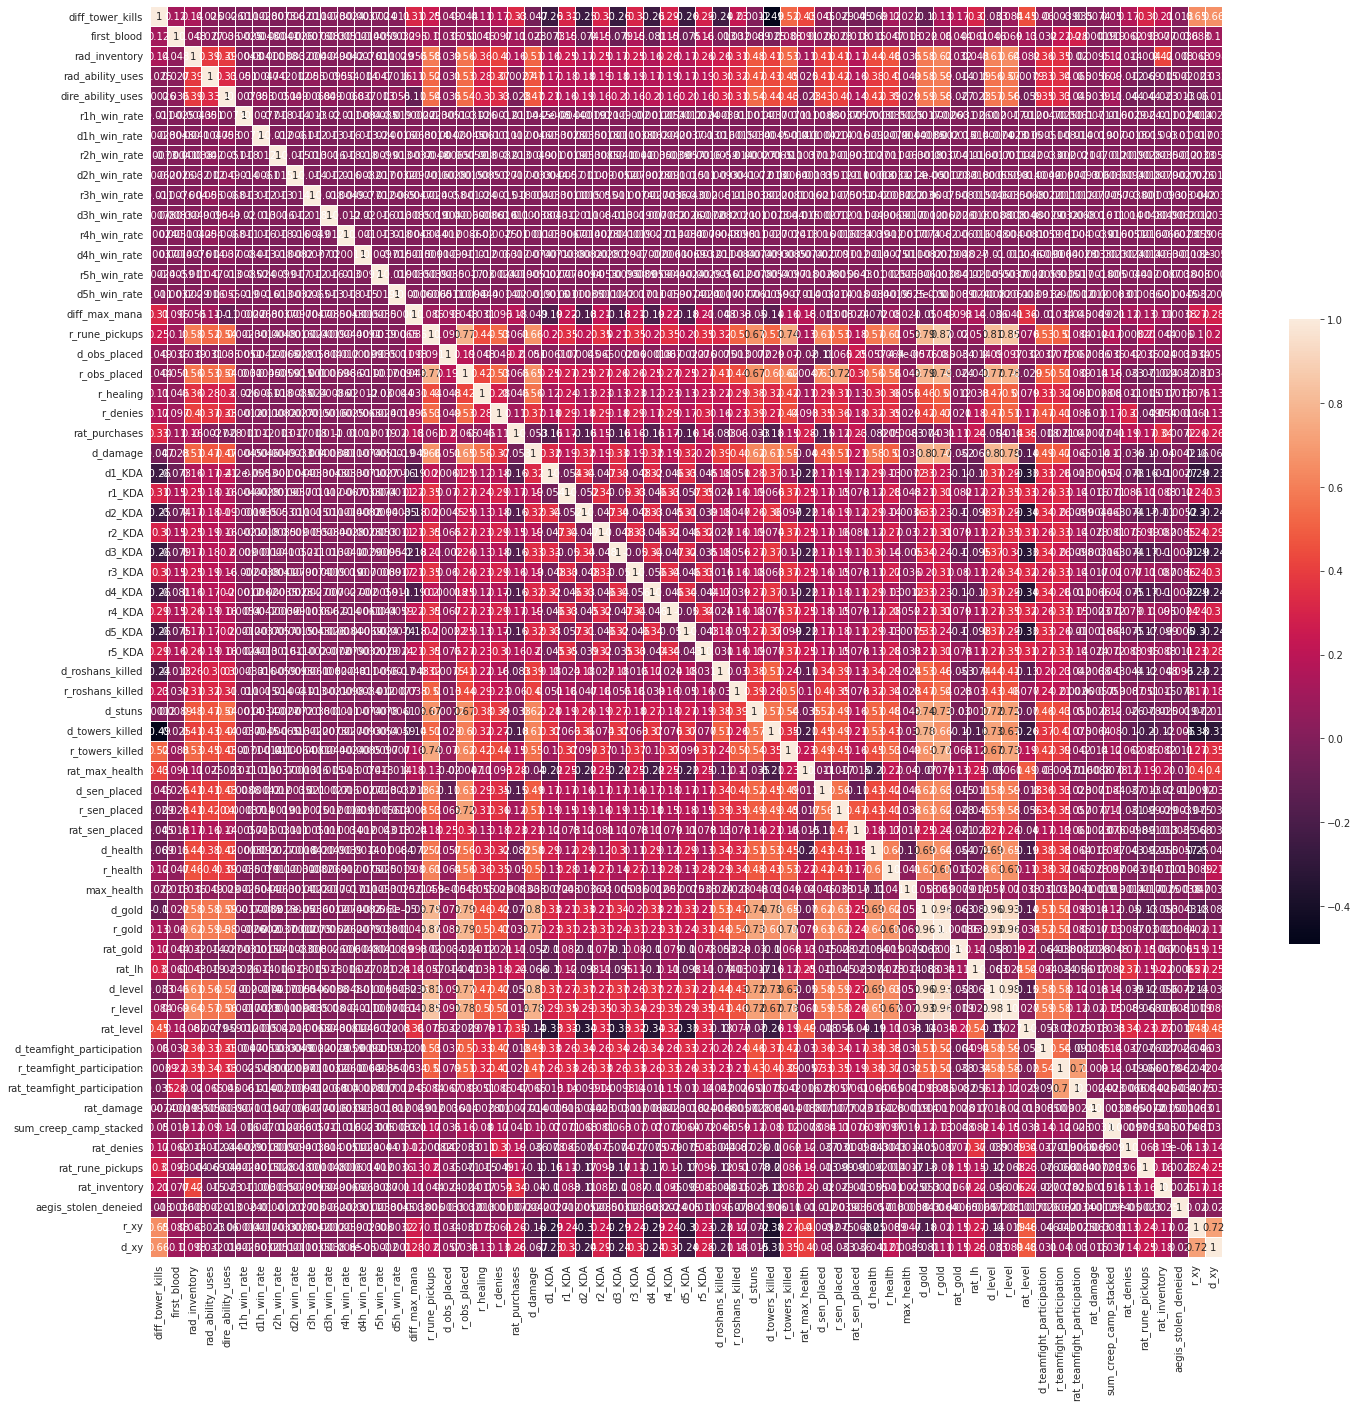

In [325]:
plt.figure(figsize=(24, 23))
sns.heatmap(train[['diff_tower_kills', 'first_blood', 'rad_inventory', 
                   'rad_ability_uses', 'dire_ability_uses', 'r1h_win_rate', 
                   'd1h_win_rate', 'r2h_win_rate', 'd2h_win_rate', 'r3h_win_rate', 
                   'd3h_win_rate', 'r4h_win_rate', 'd4h_win_rate', 'r5h_win_rate', 
                   'd5h_win_rate', 'diff_max_mana', 'r_rune_pickups', 'd_obs_placed', 
                   'r_obs_placed', 'r_healing', 'r_denies', 'rat_purchases', 'd_damage', 
                   'd1_KDA', 'r1_KDA', 'd2_KDA', 'r2_KDA', 'd3_KDA', 'r3_KDA', 'd4_KDA', 
                   'r4_KDA', 'd5_KDA', 'r5_KDA', 'd_roshans_killed', 'r_roshans_killed', 
                   'd_stuns', 'd_towers_killed', 'r_towers_killed', 'rat_max_health', 
                   'd_sen_placed', 'r_sen_placed', 'rat_sen_placed', 'd_health', 'r_health', 
                   'max_health', 'd_gold', 'r_gold', 'rat_gold', 'rat_lh', 'd_level', 
                   'r_level', 'rat_level', 'd_teamfight_participation', 'r_teamfight_participation', 
                   'rat_teamfight_participation', 'rat_damage', 'sum_creep_camp_stacked', 
                   'rat_denies', 'rat_rune_pickups', 'rat_inventory', 'aegis_stolen_deneied', 
                   'r_xy', 'd_xy'
                  ]].corr(),
            linewidths=0.5, 
            annot=True,
            cbar_kws={"shrink": 0.5})

In [331]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Тест

In [317]:
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED,
                        n_jobs=2)

lr.fit(train_scaled, y)

coefficients = np.hstack((lr.intercept_, lr.coef_[0]))
coefficients_df = pd.DataFrame(data={'variable': ['intercept'] + list(train.columns), 'coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False, key=lambda col: col.abs())

In [318]:
scores = cross_val_score(lr, train_scaled, y, cv=3, scoring="roc_auc")
print(f"{lr.__class__.__name__}: {scores.mean()}")
# LogisticRegression: 0.8105232298578847
# LogisticRegression: 0.8107347130416839
# LogisticRegression: 0.810941765578241
# LogisticRegression: 0.8111139580828519
# LogisticRegression: 0.8112648829339387
# LogisticRegression: 0.8112687749635854
# LogisticRegression: 0.8113630693326256
# LogisticRegression: 0.8119712219496457
# LogisticRegression: 0.8122969316307732
# LogisticRegression: 0.8123944574517011
# LogisticRegression: 0.8128608374551053
# LogisticRegression: 0.8129872586252871
# LogisticRegression: 0.8130763174865153
# LogisticRegression: 0.8132250386671416

# LogisticRegression: 0.8132644733566305
# LogisticRegression: 0.8133530536171455
# LogisticRegression: 0.8134436703592831
# LogisticRegression: 0.8138195499389459
# LogisticRegression: 0.8139630243348902
# LogisticRegression: 0.8142539523274858

# LogisticRegression: 0.8151582034478485
# LogisticRegression: 0.815599608624373
# LogisticRegression: 0.8156045783311573
# LogisticRegression: 0.8155726873510396
# LogisticRegression: 0.8155797885913502
# LogisticRegression: 0.8157410469331051
# LogisticRegression: 0.8156962000854211
# LogisticRegression: 0.8157315265373138
# LogisticRegression: 0.815526211487776

# LogisticRegression: 0.8154044368609757
# LogisticRegression: 0.8154047722011453
# LogisticRegression: 0.815429704447268
# LogisticRegression: 0.8154178133279627
# LogisticRegression: 0.816003475660664

# LogisticRegression: 0.8160789074734427
# LogisticRegression: 0.8160978886818543
# LogisticRegression: 0.8165489119054375
# LogisticRegression: 0.8165509599067894
# LogisticRegression: 0.8165710533889431
# LogisticRegression: 0.816569437011139

LogisticRegression: 0.816569437011139


In [322]:
coefficients_df.iloc[:15,:]

,variable,coefficient
47,r_gold,1.896287
46,d_gold,-1.880177
50,d_level,-1.128610
51,r_level,1.082112
1,diff_tower_kills,0.323867
52,rat_level,0.229904
44,r_health,0.198359
43,d_health,-0.193110
22,rat_purchases,0.128825
59,rat_rune_pickups,0.118602


In [323]:
coefficients_df.iloc[50:,:]

,variable,coefficient
56,rat_damage,0.020096
35,r_roshans_killed,0.015811
20,r_healing,0.013288
15,d5h_win_rate,-0.013074
36,d_stuns,0.012214
7,d1h_win_rate,-0.011596
60,rat_inventory,0.010696
10,r3h_win_rate,0.010395
45,max_health,-0.009002
24,d1_KDA,-0.008086


In [321]:
rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=2, 
                            random_state=SEED)

rf.fit(train_scaled, y)

scores = cross_val_score(rf, train_scaled, y, cv=3, scoring="roc_auc")
print(f"{rf.__class__.__name__}: {scores.mean()}")

# RandomForestClassifier: 0.792346761151754
# RandomForestClassifier: 0.7926450328906629
# RandomForestClassifier: 0.7938552075761057
# RandomForestClassifier: 0.7957631483744102
# RandomForestClassifier: 0.7975203260227545
# RandomForestClassifier: 0.8001426009025329
# RandomForestClassifier: 0.8023725251718545
# RandomForestClassifier: 0.8145034404055558
# RandomForestClassifier: 0.8189758961060251
# RandomForestClassifier: 0.8183819598971618
# RandomForestClassifier: 0.8185396614974323
# RandomForestClassifier: 0.8186858298054739
# RandomForestClassifier: 0.81941361118888
# RandomForestClassifier: 0.819450103718092
# RandomForestClassifier: 0.8191578953569013
# RandomForestClassifier: 0.8193155884625917
# RandomForestClassifier: 0.81837592407674

RandomForestClassifier: 0.81837592407674


# Посылки

In [310]:
# Score: 0.83629
# LAST Score: 0.83371

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
xgb_rf =  xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)


base_models = [("RF", rf), ("CAT", cat), ("XGB_RF", xgb_rf), ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

# Score: 0.82324


[21:27:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Файл посылки сохранен, как: submission_2022-04-03_21-27-39.csv


In [332]:
# Score: 0.83629
# LAST Score: 0.83537

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
xgb_rf =  xgboost.XGBRFClassifier(random_state=SEED)
etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                           n_estimators=500, n_jobs=-1, random_state=SEED)


base_models = [("RF", rf), ("CAT", cat), ("XGB_RF", xgb_rf), ('etc', etc)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

[21:36:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Файл посылки сохранен, как: submission_2022-04-03_21-36-45.csv


In [312]:
# Score: 0.83124
# LAST Score: 0.83158

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
rf.fit(train_scaled, y)

y_test_pred = rf.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_21-28-34.csv


In [313]:
# NOW Score: 0.82103

lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED,
                        n_jobs=2)

lr.fit(train_scaled, y)

y_test_pred = lr.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_21-28-40.csv
